In [ ]:
import nltk
from nltk.stem.porter import *
from nltk.classify import MaxentClassifier
import pickle
import os,sys
from io import open


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/My Drive/Assignment2'

/content/drive/My Drive/Assignment2


In [ ]:

change_of_sentence_flag = 0 #a marker for the end of sentence
boi_full_list = [] #store all the boi tags that occur in the training set
boi_end_list = [] #store boi tags that are at the end of the sentence
wordStartList = [] #store words that are begining of the sentence
BOI_list = ['B', 'I', 'O']
labeled_features = []

training_file = open("data/train.txt", "r")
testing_file = open("data/test.txt", "r")

#****************************************************************building input features part.1
previous_BOI = "Start"
previous_previous_BOI = "Start"
prev_tag = "^"
prev_prev_tag = "^"
prev_word = "^"
prev_prev_word = "^" 

input_file = training_file
for i,line in enumerate(input_file):
    s = line == '\n'
    if s:
        change_of_sentence_flag = 1
        previous_BOI = "Start"
        previous_previous_BOI = "Start"
        prev_tag = "^"
        prev_prev_tag = "^"
        prev_word = "^"
        prev_prev_word = "^"

    else:
        #print(sentenceList)
        sentenceList = line.split()
        word = sentenceList[0]
        tag = sentenceList[1]
        boi = sentenceList[2][0] 

        #store words that are begining of the sentence
        if change_of_sentence_flag == 1:
            wordStartList.append(word)
            boi_end_list.append(boi_full_list[-1])
            change_of_sentence_flag = 0
        boi_full_list.append(boi)
        item = (word, prev_word, prev_prev_word, tag, prev_tag, prev_prev_tag, previous_BOI, previous_previous_BOI, boi)
        labeled_features.append(item)

        previous_previous_BOI = previous_BOI
        previous_BOI = boi
        prev_prev_tag = prev_tag
        prev_tag = tag
        prev_prev_word = prev_word 
        prev_word = word
            #labeled_features 


#print(labeled_features)
#unlabeled_features = []

input_file.close()
#****************************************************************calculate End Transition
#calculate the End prior
dicE = {} #temporarry dic 

#calculate the prior (End|state) = C(state, End)/C(state) 
for i in BOI_list:
    countTag = boi_full_list.count(i)
    countEnd = boi_end_list.count(i)
    ProbE = format(countEnd/(countTag*1.0), '.5f')
    dicE.update({i: {"END":ProbE}})


In [ ]:
#****************************************************************building input features part.2
def MEMM_features(item):
    stemmer = PorterStemmer() 
    features = {}
    features['current_word'] = item[0]
    # features['current_tag'] = item[3]
    features['prev_word'] = item[1]
    # features['prev_tag'] = item[4]
    features['prev_prev_word'] = item[2]
    # features['prev_prev_tag'] = item[5]
    features['prev_chunk'] = item[6]
    features['prev_prev_chunk'] = item[7]

    features['capitalization'] = word[0].isupper()
    features['start_of_sentence'] = word in wordStartList
    features['cap_start'] = word not in wordStartList and word[0].isupper()

    return features

In [ ]:
#*******************************************************************train the model

labeled_featuresets = [(MEMM_features(item[:-1]),item[-1]) for item in labeled_features]
train_set = labeled_featuresets

f = open("my_classifier.pickle", "wb")
maxent_classifier = MaxentClassifier.train(train_set, max_iter=25)
pickle.dump(maxent_classifier , f)
f.close() 

  ==> Training (25 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.132
             2          -0.63447        0.774
             3          -0.49117        0.853
             4          -0.40633        0.890
             5          -0.35158        0.908
             6          -0.31348        0.917
             7          -0.28539        0.923
             8          -0.26375        0.928
             9          -0.24649        0.932
            10          -0.23235        0.935
            11          -0.22051        0.937
            12          -0.21041        0.940
            13          -0.20168        0.941
            14          -0.19404        0.943
            15          -0.18727        0.947
            16          -0.18122        0.948
            17          -0.17577        0.950
            18          -0.17083        0.951
            19          -0.16633        0.952
  

In [ ]:
#********************************************************************Viterbi
def MEMM(wordList,tagList):
    previous_BOI = "Start"
    previous_previous_BOI = "Start"
    prev_tag = "^"
    prev_prev_tag = "^"
    prev_word = "^"
    prev_prev_word = "^"
    BOI_list = ['B', 'I', 'O']
  
    w1 = wordList[0]
    t1 = tagList[0]
    tRange = len(BOI_list)
    wRange = len(wordList)

    item = [w1, prev_word, prev_prev_word, t1, prev_tag, prev_prev_tag, previous_BOI, previous_previous_BOI]

    viterbi = [[0 for x in range(300)] for x in range(10)] 
    backpointer = [['' for x in range(300)] for x in range(10)] 

    for t in range(tRange):#t = 0,1,2
        probability = maxent_classifier.prob_classify(MEMM_features(item)) 
        posterior = float(probability.prob(BOI_list[t]))
        viterbi[t][1] = posterior
        backpointer[t][1] = 'Start'

    #for word w from 2 to T
    maxViterbi = 0
    maxPreviousState = 0 
    for w in range (1, wRange):
        word = wordList[w]
        tag = tagList[w]
        item[2] = item[1]
        item[1] = item[0]
        item[0] = word
        item[5] = item[4]
        item[4] = item[3]
        item[3] = tag

        for t in range (tRange):
            item[6] = BOI_list[0]
            item[7] = backpointer[0][w]
            probability = maxent_classifier.prob_classify(MEMM_features(item)) 
            posterior = float(probability.prob(BOI_list[t]))
            maxViterbi = float(viterbi[0][w]) * posterior
            maxPreviousState = 0
            for i in range (1, tRange):
                item[6] = BOI_list[i]
                item[7] = backpointer[i][w]
                probability = maxent_classifier.prob_classify(MEMM_features(item)) 
                posterior = float(probability.prob(BOI_list[t]))
                if float(viterbi[i][w]) * posterior > maxViterbi:
                    maxViterbi = float(viterbi[i][w]) * posterior
                    maxPreviousState = i
            viterbi[t][w+1] = maxViterbi
            backpointer[t][w+1] = BOI_list[maxPreviousState]
            
            maxViterbi = 0
            maxPreviousState = 0 

    #viterbi[qF, T] = max (viterbi[s,T] *as,qF)
    maxPreTerminalProb = float(viterbi[0][wRange] )* float(dicE[BOI_list[0]]["END"])

    maxPreviousState = 0
    for i in range (1, tRange):	
        if float(viterbi[i][wRange]) * float(dicE[BOI_list[i]]["END"]) > maxPreTerminalProb:
            maxPreTerminalProb = float(viterbi[i][wRange]) * float(dicE[BOI_list[i]]["END"]) 
            maxPreviousState = i

    viterbi[tRange][wRange+1] = maxPreTerminalProb 
    backpointer[tRange][wRange+1] = BOI_list[maxPreviousState]
    #return POS tag path 
    pathReverse = [BOI_list[maxPreviousState]]
    maxPreviousTag = BOI_list[maxPreviousState]

    i = 0
    while i < (wRange -1):
        pathReverse.append(backpointer[BOI_list.index(maxPreviousTag)][wRange - i])
        maxPreviousTag = backpointer[BOI_list.index(maxPreviousTag)][wRange - i]
        i = i + 1 

    #reverse the path to make it correct
    index = len(pathReverse)
    path = []
    while index >= 1 :
        path.append(pathReverse[index - 1])
        index = index -1 
    return path


In [ ]:
#*******************************************************************MaxEnt+Viterbi = MEMM
#main()
output_file = open("boi_output.txt", "w")
wordList = []
tagList = []
boiList = []
BOI_list = ['B', 'I', 'O']
full_boiList = []
full_path = []

input_file = testing_file
for line in input_file:	
    if line.strip() != '':
        sentenceList = line.split()
        word = sentenceList[0]
        tag = sentenceList[1]
        boi = sentenceList[2][0]
        wordList.append(word)
        tagList.append(tag)
        boiList.append(boi)
        full_boiList.append(boi)

    s = re.match("\n", line)
    if s:
        path = MEMM(wordList, tagList)
        
        for i in range(len(wordList)):
            output_file.write(wordList[i]+"	"+ tagList[i]+ " " + boiList[i] + " " + path[i] + "\n")
            full_path.append(path[i])
        output_file.write("\n")
        wordList = []
        tagList = []
        boiList = []
        labeled_features = []

input_file.close()
output_file.close()

In [ ]:
print(len(full_boiList),len(full_path))

47377 47377


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd


In [ ]:
cm = confusion_matrix(full_boiList, full_path,labels=BOI_list)
pd_confusion = pd.DataFrame((cm), columns=BOI_list,index=BOI_list)


In [ ]:
pd_confusion

,B,I,O
B,22175,1585,92
I,1397,15641,307
O,184,287,5709


In [ ]:
print(classification_report(full_boiList, full_path, BOI_list))

              precision    recall  f1-score   support

           B       0.93      0.93      0.93     23852
           I       0.89      0.90      0.90     17345
           O       0.93      0.92      0.93      6180

    accuracy                           0.92     47377
   macro avg       0.92      0.92      0.92     47377
weighted avg       0.92      0.92      0.92     47377



In [ ]:
def plot_confusion_matrix(cm, tag_list):
  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy
  cm = cm.astype('float')/(cm.sum(axis=1).reshape((len(tag_list),1)))
  cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(12, 9))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title('Confusion matrix')
  plt.colorbar()

  tick_marks = np.arange(len(tag_list))
  plt.xticks(tick_marks, tag_list)
  plt.yticks(tick_marks, tag_list)

  thresh = cm.max() / 1.5
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
      
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

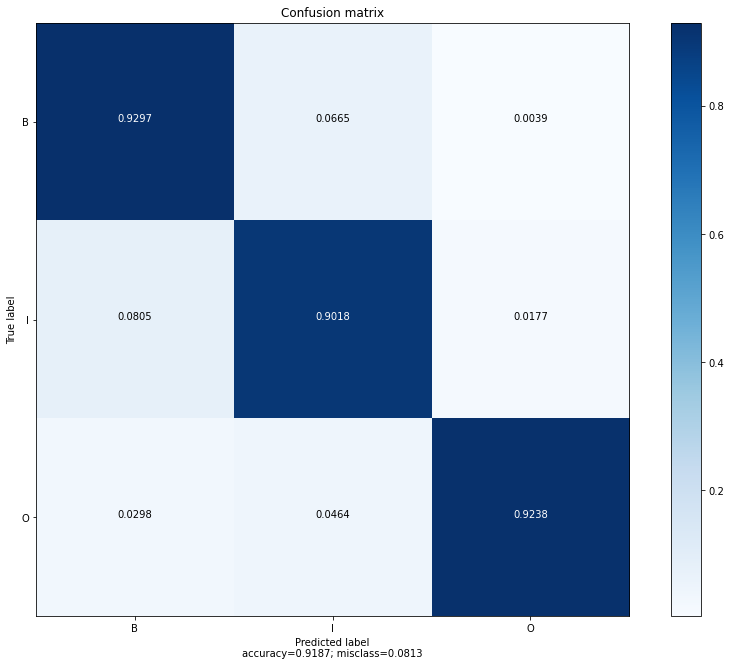

In [ ]:
plot_confusion_matrix(cm, BOI_list)
